In [1]:
# show C-level stderr/stdout
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import copy
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, TensorDataset
import random

from tqdm.notebook import tqdm

In [4]:
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from nuq import NuqClassifier

matplotlib.rcParams.update({'font.size': 12})


def plot_data(X, y, title=None):
    plt.close()
    plt.figure()
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.tight_layout()
    plt.show()


def make_data(total_size=5000, centers=np.array([[-4., -4.], [0., 4.]])):
    X, y = make_blobs(n_samples=total_size, n_features=2, centers=centers)
    return X, y

In [5]:
np.c_[[1, 2], [3, 4]]

array([[1, 3],
       [2, 4]])

In [6]:
a = np.random.choice(5, (10, ),)
print(f"{a = }")
np.unique(a, return_inverse=True, return_index=True)

a = array([4, 2, 2, 2, 0, 3, 2, 4, 3, 4])


(array([0, 2, 3, 4]),
 array([4, 1, 5, 0]),
 array([3, 1, 1, 1, 0, 2, 1, 3, 2, 3]))

In [11]:
# Number of points
N = 30
# Number of classes
k = 3
# Dimensonality
d = 2
strategy = "isj"

X = np.random.uniform(size=(N, d))
y = np.random.choice(np.arange(k), N)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

nuq = NuqClassifier(n_neighbors=5, strategy=strategy.lower(), tune_bandwidth=True)
nuq.fit(X_train, y_train)

nuq.predict_proba(X_val, return_uncertainty=True)

bandwidth = array([0.01063474, 0.01567899])


(array([[0.49992788, 0.        , 0.        ],
        [0.5       , 0.        , 0.        ],
        [0.49999997, 0.        , 0.        ],
        [0.5       , 0.        , 0.        ],
        [0.5       , 0.        , 0.        ],
        [0.5       , 0.        , 0.        ]], dtype=float32),
 array([2.58728172, 2.58760964, 3.25572598, 2.58760965, 3.25572614,
        2.58760965]))

In [49]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(f"{a = }")
np.c_[a, [10, 20]]

a = array([[1, 2, 3],
       [4, 5, 6]])


array([[ 1,  2,  3, 10],
       [ 4,  5,  6, 20]])

In [34]:
i = 3
a = np.arange(10)
print(a)

np.sum(a[:i]) + np.sum(a[i+1:])

[0 1 2 3 4 5 6 7 8 9]


42

X_test.shape = (46551, 2)
bandwidth = array([0.18052822, 0.26230581])


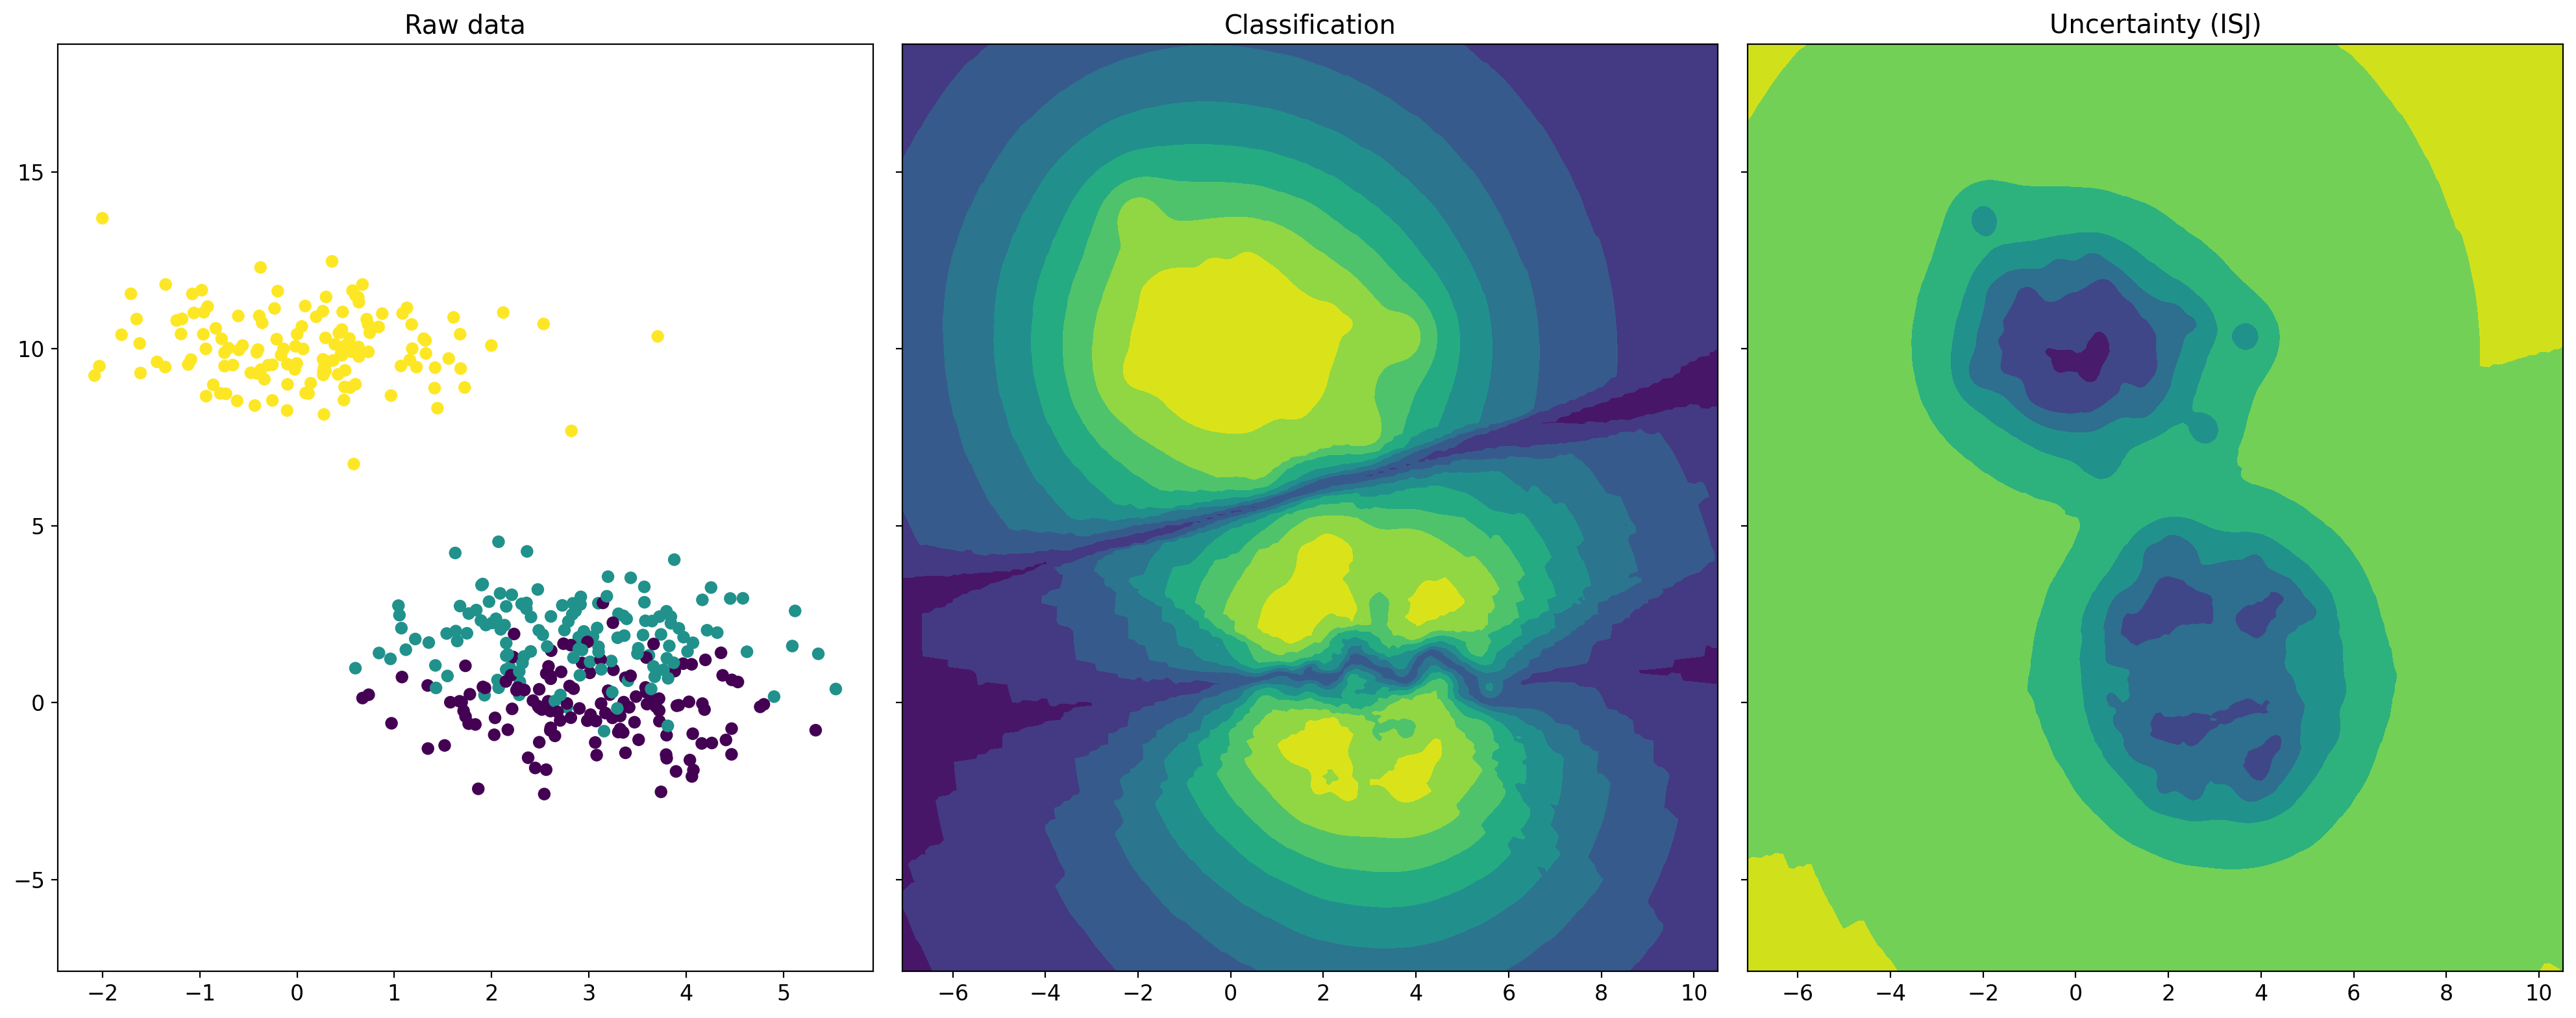

In [41]:
## Make a dataset
X, y = make_data(total_size=500, #total_size=10_000,
                 centers=np.array([[3., 0.], [3., 2.], [0., 10]]))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

# h_x, h_y = 0.05, 0.05
h_x, h_y = [0.1] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x),
                     np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]
print(f"{X_test.shape = }")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=200, sharey=True)
ax[0].set_title("Raw data")
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# strategy options: 'isj', 'silverman', 'scott', 'classification'
for i, strategy in enumerate(["ISJ"]):#, "Classification"]):
    nuq = NuqClassifier(strategy=strategy.lower(), tune_bandwidth=True,
                        kernel_type="student", mixture_weight=1e-1,
                        n_neighbors=20, bandwidth=np.array([1., 1.]))
    nuq.fit(X=X_train, y=y_train)

    ax[1].set_title("Classification")
    probs, uncertainty = nuq.predict_proba(X_test, return_uncertainty=True)
    ax[1].contourf(xx, yy, np.max(probs, axis=-1).reshape(*xx.shape))

    ax[i + 2].set_title(f"Uncertainty ({strategy})")
    ax[i + 2].contourf(xx, yy, uncertainty.reshape(*xx.shape))

plt.tight_layout()
plt.show()

In [44]:
fig.savefig("student_nuq.pdf")

In [6]:
a = np.random.choice(np.arange(3), 10)

_, counts = np.unique(a, return_counts=True)
counts / a.shape[0]

array([0.4, 0.3, 0.3])

In [128]:
uncertainty == -np.inf

array([ True,  True,  True, ..., False, False, False])

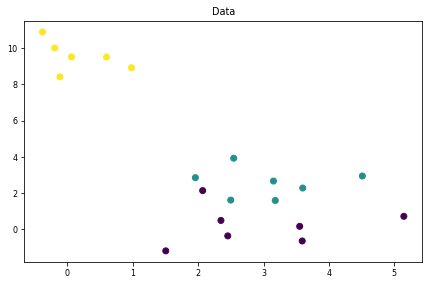

self.X_.shape = (16, 2), self.y_.shape = (16,)
bandwidth = array([0.46932892, 0.75117281])
X_cur.shape = (24, 2)


NameError: name 'compute_weights' is not defined

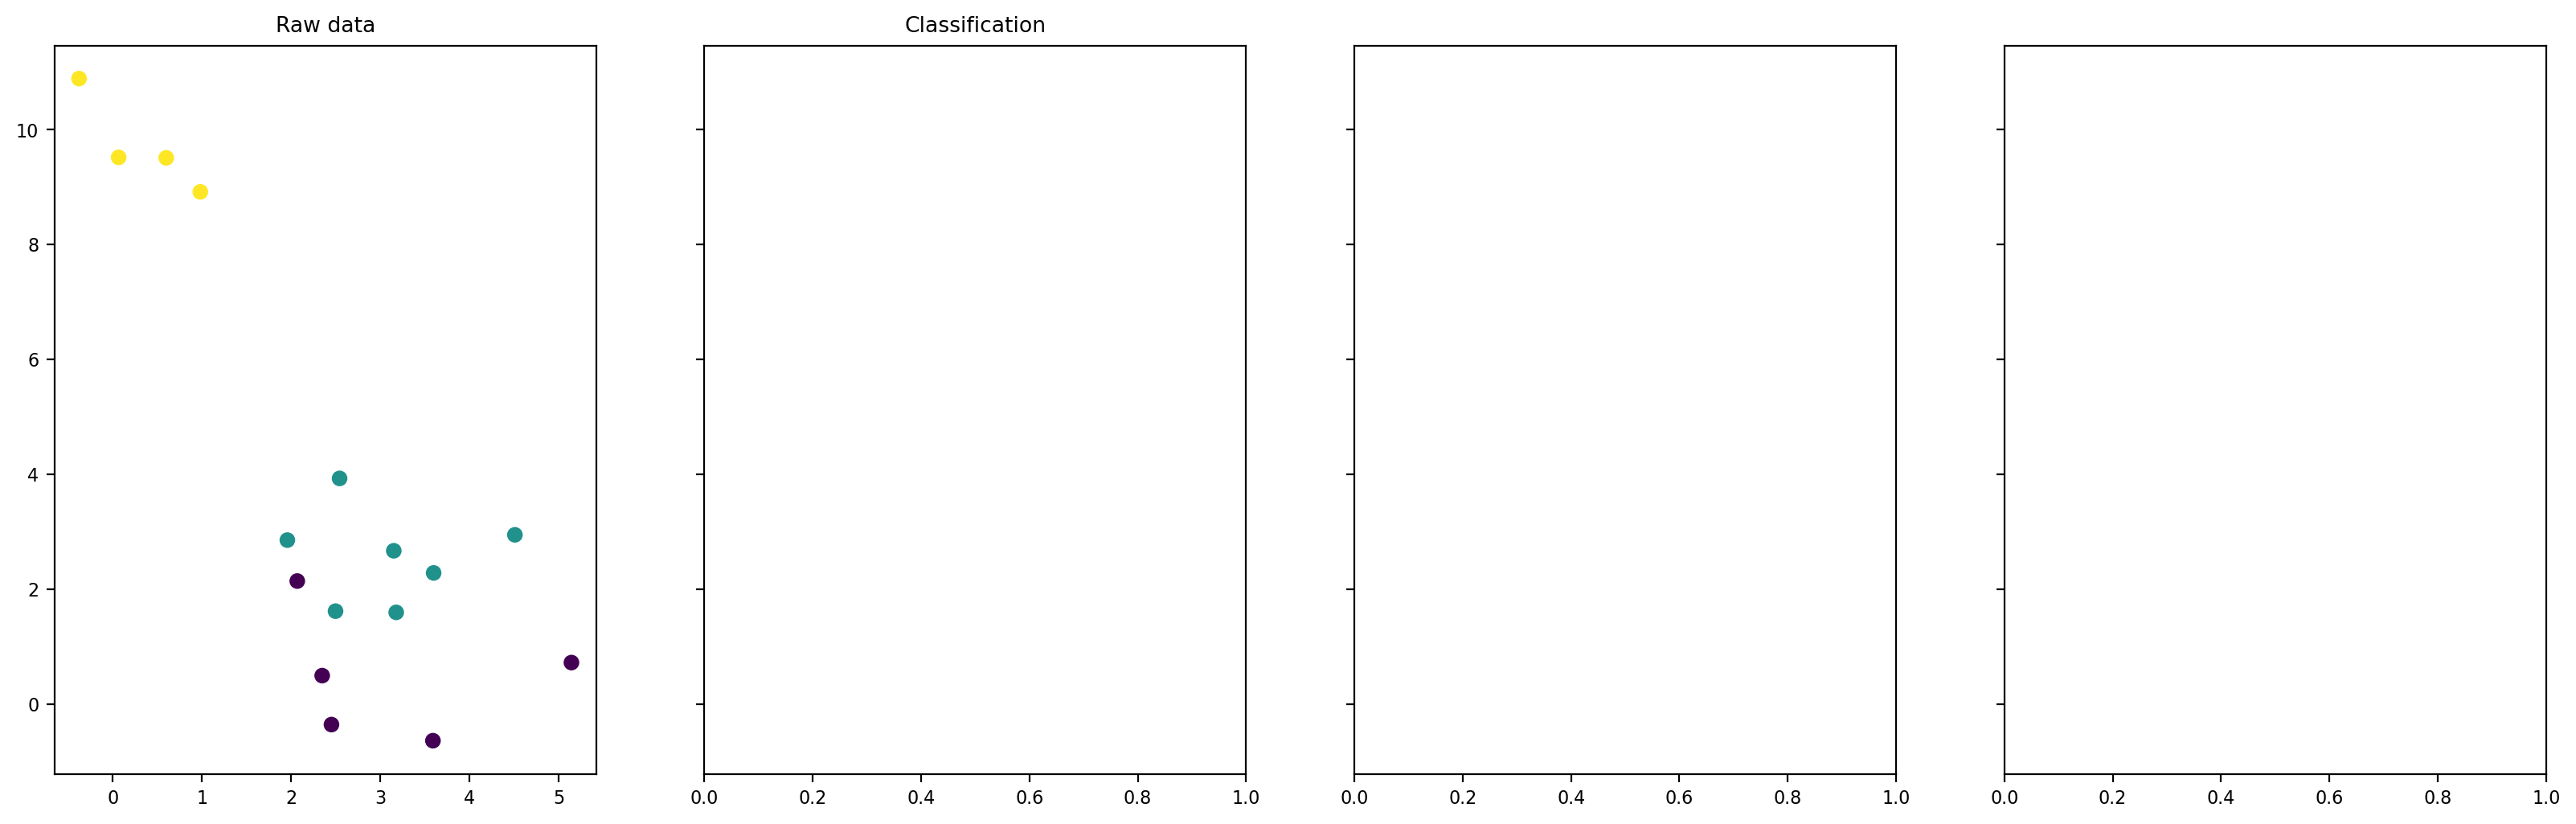

In [13]:
## Make a dataset
X, y = make_data(total_size=20, #total_size=10_000,
                 centers=np.array([[3., 0.], [3., 2.], [0., 10]]))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
plot_data(X, y, 'Data')

x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

# h_x, h_y = 0.05, 0.05
h_x, h_y = [4.] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x),
                     np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), dpi=200, sharey=True)
ax[0].set_title('Raw data')
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# strategy options: 'isj', 'silverman', 'scott', 'classification'
# uncertainty type options: 'aleatoric', 'epistemic', 'total'
uncertainty_type = "aleatoric"

for i, strategy in enumerate(['ISJ', 'Classification']):
    # precise_computation = True
    precise_computation = False
    nuq = NuqClassifier(bandwidth=np.array([0.4, 0.4]), strategy=strategy.lower(), tune_bandwidth=True,
                        n_neighbors=10, coeff=1e-10)
    nuq.fit(X=X_train, y=y_train)

    ax[1].set_title('Classification')
    f_hat_y_x = nuq.predict_proba(X_test)["probs"]
    ax[1].contourf(xx, yy, np.max(f_hat_y_x, axis=-1).reshape(*xx.shape))

    ax[i + 2].set_title(f'Uncertainty {uncertainty_type}, {strategy}')
    uncertainty = nuq.predict_uncertainty(X_test)
    Ue = uncertainty[uncertainty_type]
    if precise_computation:
        ax[i + 2].contourf(xx, yy, Ue.reshape(*xx.shape))
    else:
        ax[i + 2].contourf(xx, yy, np.log(Ue.reshape(*xx.shape)))

    print(f"{strategy}, {[10., 0.]}: {nuq.predict_uncertainty(np.array([[10., 0.]]))}, "
          f"{[0., 0.]}: {nuq.predict_uncertainty(np.array([[0., 0.]]))},"
          f"{[20., 20.]}: {nuq.predict_uncertainty(np.array([[20., 20.]]))}")
plt.tight_layout()
plt.show()